In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import plotly.express as px
import warnings

from tqdm.notebook import tqdm

import pickle
import plotly.io as pio
pio.renderers.default = "svg"

layout = {
    'showlegend': True,
    'margin': {'b':10, 'l':20, 'r':50, 't':50},
    'font': {'size': 19},
    'xaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'yaxis': {'zerolinewidth': 2, 'zerolinecolor':'black'},
    'template': 'plotly_white',
}

px.defaults.color_discrete_sequence = px.colors.qualitative.T10

# Import Quoilin dataset
Data available at: https://github.com/squoilin/Self-Consumption/releases Synthetic.Household.Profiles.h5

In [2]:
df = pd.read_pickle("../2_chapter/fr_quoilin_data_valence.pickle")
df.columns

Index(['2000900', '2000901', '2000903', '2000904', '2000905', '2000906',
       '2000907', '2000908', '2000909', '2000910',
       ...
       '2001188', '2001189', '2001190', '2001192', '2001193', '2001194',
       '2001195', '2001197', '2001199', 'pv_1kw'],
      dtype='object', length=174)

# Set study on 20 households

In [3]:
nb_houses = 20

In [4]:
house_ids=[
    "2000989",
    "2001197",
    "2000914",
    "2001123",
    "2000964",
    "2001189",
    "2001111",
    "2001179",
    "2000909",
    "2000918",
    "2000994",
    "2001107",
    "2000913",
    "2001139",
    "2000960",
    "2001149",
    "2001165",
    "2000954",
    "2001114",
    "2000926",
]
df = df[house_ids + ["pv_1kw"]]
print(f"Average consumption is {round((df[house_ids].sum() * 15 / 60).mean() / 1000, 2)} MWh")

Average consumption is 5.56 MWh


In [5]:
_individuals = df.copy()
df["community_kW"] = df[house_ids].sum(axis=1)
df.drop(house_ids, axis=1, inplace=True)

In [6]:
individuals = _individuals.copy()

# Fix variables
deltat = timedelta(minutes=15)

# Training = 31 days + 1 day for lagged values
training = timedelta(days=31)

# Where do we forecast?
start = datetime(2019, 5, 30, 6, 0, 0)
full_horizon = timedelta(days=7)

# When do we calibrate
start_calibrate = start - timedelta(days=2)
end_calibrate = start - deltat
start_training_to_calibrate = start_calibrate - training
end_training_to_calibrate = start_calibrate - deltat

# To truncate data
end = start + full_horizon + timedelta(days=7)  # keep a few days after anyway

pv_size = 3
individuals = individuals.loc[start_training_to_calibrate-timedelta(days=1):end, :].copy()
for col in individuals.columns:
    individuals[col] -= pv_size * individuals["pv_1kw"]
individuals.drop(columns=["pv_1kw"], inplace=True)

sub_house_ids = [house_ids[i] for i in [0, 4, 19, 13, 14]]

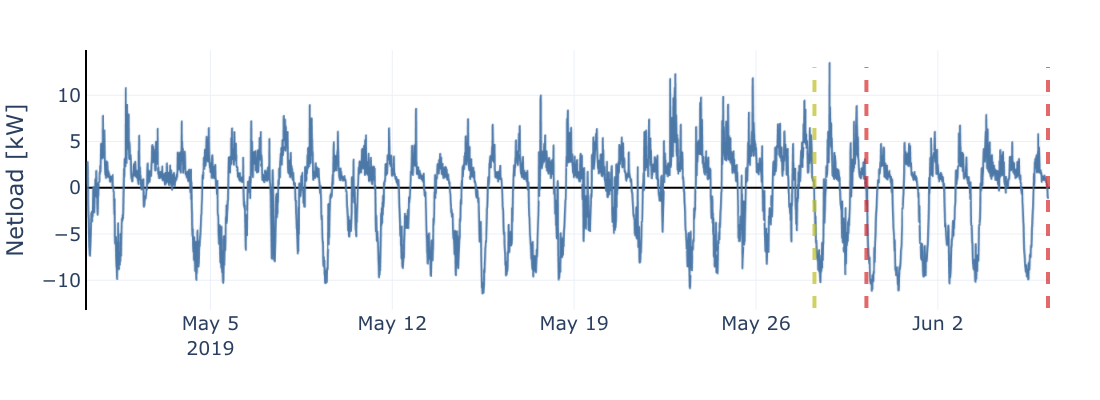

In [7]:
graph = individuals.loc[start-training+timedelta(days=1):end-timedelta(days=7), sub_house_ids].sum(axis=1).copy()

fig = px.line(graph)
fig.data[0].update(line_width=2)

# Red dashed line
fig.add_shape(
 type='line',
 x0=start, x1=start, y0=-13, y1=13,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

# Red dashed line
fig.add_shape(
 type='line',
 x0=start+full_horizon-deltat,
 x1=start+full_horizon-deltat, y0=-13, y1=13,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(214, 39, 40, 0.7)'})

# Red dashed line
fig.add_shape(
 type='line',
 x0=start_calibrate,
 x1=start_calibrate, y0=-13, y1=13,
 line={'dash': 'dash', 'width': 4,
       'color': 'rgba(188, 189, 34, 0.7)'})

fig.update_layout(
    layout,
    height=400,
    width=1100,
    showlegend=False,
    xaxis_title="",
    yaxis_title="Netload [kW]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show(renderer="png")
#fig.write_image(f"results/mpc_inputs.svg")

# ------ Section by-passed with (batch_forecast.py)

In [8]:
def get_gof(df, result, ref_col, pred_col):
    """
    gof = (1 - NRMSE) * 100
    """
    pred = result.loc[:, [pred_col]].copy()
    #if pred.index.tzinfo is None:
    #    pred.index = pred.index.tz_localize("UTC")
    pred.columns = ["prediction"]

    ref = df.loc[pred.index[0]:pred.index[-1], [ref_col]].copy()
    ref.columns = ["target"]

    nrmse = (np.linalg.norm(ref["target"].values - pred["prediction"].values, 2) 
           / np.linalg.norm(ref["target"].values - ref["target"].mean(), 2))
    return 100.0 * (1.0 - np.clip(nrmse, a_min=0.0, a_max=1.0))

start_training = start - training
end_training = start - deltat

horizon = timedelta(days=2) - deltat
end_complete_pred = start + timedelta(days=7)

freqs = ["2D"]
freq_deltas = [timedelta(days=2) - deltat]

# Forecast at freq = 2 days

In [9]:
house_forecast = {}

for freq in freqs:
    with open(f'tmp_forecasts/house_forecast_{freq}.pickle', 'rb') as handle:
        unserialized_data = pickle.load(handle)
    house_forecast[freq] = unserialized_data
    
# Reformat as a dict of freq with a list of pd.DataFrame with all houses.
house_forecast_list = {}

for freq in freqs:
    house_forecast_list[freq] = []
    
    for i in range(0, len(house_forecast[freq][sub_house_ids[0]])):
        tmp = pd.concat([house_forecast[freq][house_id][i] for house_id in sub_house_ids], axis=1)
        house_forecast_list[freq].append(tmp)

### Profiles

In [ ]:
f = 0
freq = freqs[f]
freq_delta = freq_deltas[f]
print(freq)

for house_id in sub_house_ids:
    graph = individuals.loc[start:end_complete_pred, [house_id]].copy()
    graph.columns = ["Ref"]

    fig = px.line(graph)
    fig.data[0].update(line_width=3)
    
    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    graph = pd.concat(tmp, axis=0)

    trace = px.line(graph[house_id].loc[start:end_complete_pred]).data[0]
    fig.add_trace(trace)
    fig.data[-1].update(line_width=3, line_color="rgba(255, 127, 14, 0.7)")

    fig.update_layout(
        layout,
        height=400,
        width=900,
        showlegend=False,
        xaxis_title="",
        yaxis_title="Netload [kW]",
        yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
        xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
        xaxis_tickangle=0)
    fig.show()

# Optimize at freq =2 days

In [10]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "glpk"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_energy(m, b):
            return m.batteryenergy[m.last, b] >= batteries[b]["end_kwh"]

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )

        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
#--->?? #m.r6 = Constraint(m.batteries, rule=r_battery_end_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum(m.batteryin[i, b] for b in m.batteries)
                for i in m.horizon
            )

        m.objective = Objective(rule=objective_function, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, spec):
        netloads = df.copy()
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec[i]["min_kw"],
            "max_kw": spec[i]["max_kw"],
            "max_kwh": spec[i]["max_kwh"],
            "eta": spec[i]["eta"],
            "offset": spec[i]["offset"],
            "init_kwh": spec[i]["init_kwh"],
            #"end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

In [11]:
from pyomo.opt import SolverFactory
from pyomo.environ import *
from dataclasses import dataclass
from datetime import timedelta


@dataclass
class OptimizeBatteries_quadratic:
    grid_buy: float
    grid_fee: float
    battery_aging_cost: float = 0.0
    only_return_schedules: bool = True
    freq: int = 15
    optim_horizon: timedelta = timedelta(days=2)
    solver: str = "gurobi"
    solver_path: str = None
    verbose: bool = False
    
    def _solve(self, netloads, members, assets):
        m = ConcreteModel()
        batteries = assets["batt"]

        m.horizon = Set(initialize=list(netloads.keys()), ordered=True)
        m.members = Set(initialize=list(members.keys()), ordered=True)
        m.batteries = Set(initialize=list(batteries.keys()), ordered=True)

        m.community_import = Var(m.horizon, domain=NonNegativeReals)
        m.member_import = Var(m.horizon, m.members, domain=NonNegativeReals)
        m.batteryin = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryout = Var(m.horizon, m.batteries, domain=NonNegativeReals)
        m.batteryenergy = Var(m.horizon, m.batteries, domain=NonNegativeReals)

        m.grid_buy = Param(initialize=self.grid_buy)
        m.grid_fee = Param(initialize=self.grid_fee)
        m.battery_aging_cost = Param(initialize=self.battery_aging_cost)
        m.deltat = Param(initialize=self.freq / 60)
        m.last = Param(initialize=m.horizon.last())

        # Battery constraints
        def r_battery_max_powerin(m, t, b):
            return m.batteryin[t, b] <= batteries[b]["max_kw"]

        def r_battery_max_powerout(m, t, b):
            return m.batteryout[t, b] <= batteries[b]["min_kw"]

        def r_battery_energy(m, t, b):
            if t == 0:
                return m.batteryenergy[t, b] == batteries[b]["init_kwh"]
            else:
                return (
                    m.batteryenergy[t, b]
                    == m.batteryenergy[t - 1, b]
                    + m.batteryin[t - 1, b] * m.deltat * batteries[b]["eta"]
                    - m.batteryout[t - 1, b] * m.deltat / batteries[b]["eta"]
                )

        def r_battery_min_energy(m, t, b):
            return (
                m.batteryenergy[t, b]
                >= batteries[b]["max_kwh"] * batteries[b]["offset"]
            )

        def r_battery_max_energy(m, t, b):
            return m.batteryenergy[t, b] <= batteries[b]["max_kwh"] * (
                1 - batteries[b]["offset"]
            )

        def r_battery_end_power_out(m, b):
            return m.batteryout[m.last, b] == 0.0

        def r_battery_end_power_in(m, b):
            return m.batteryin[m.last, b] == 0.0

        # Energy balance
        def r_community_import(m, t):
            return m.community_import[t] >= sum(
                m.batteryin[t, b] - m.batteryout[t, b] for b in m.batteries
            ) + sum(netloads[t][p] for p in m.members)

        def r_member_import(m, t, p):
            return (
                m.member_import[t, p]
                >= sum(
                    m.batteryin[t, b] - m.batteryout[t, b] for b in members[p]["batt"]
                )
                + netloads[t][p]
            )
        
        m.r1 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerin)
        m.r2 = Constraint(m.horizon, m.batteries, rule=r_battery_max_powerout)
        m.r3 = Constraint(m.horizon, m.batteries, rule=r_battery_energy)
        m.r4 = Constraint(m.horizon, m.batteries, rule=r_battery_min_energy)
        m.r5 = Constraint(m.horizon, m.batteries, rule=r_battery_max_energy)
        m.r7 = Constraint(m.batteries, rule=r_battery_end_power_out)
        m.r8 = Constraint(m.batteries, rule=r_battery_end_power_in)
        m.r9 = Constraint(m.horizon, rule=r_community_import)
        m.r10 = Constraint(m.horizon, m.members, rule=r_member_import)

        def objective_function_bis(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum((1/netloads[i][p] * (m.batteryin[i, b] + m.batteryout[i, b]))**2 for b, p in zip(m.batteries, m.members))
                for i in m.horizon
            )
     
        def objective_function(m):
            return sum(
                m.grid_buy * m.community_import[i]
                + m.grid_fee
                * (
                    sum(m.member_import[i, p] for p in m.members)
                    - m.community_import[i]
                )
                + m.battery_aging_cost * sum((m.batteryin[i, b] + m.batteryout[i, b])**2 for b in m.batteries)
                for i in m.horizon
            )
        m.objective = Objective(rule=objective_function_bis, sense=minimize)

        with SolverFactory(self.solver, executable=self.solver_path) as opt:
            results = opt.solve(m, tee=False)
            if self.verbose:
                print(results)
        return m
   
    def solve(self, df, member_ids, spec):
        netloads = df.copy()
        netloads.index = range(0, len(netloads))
        netloads = netloads.T.to_dict()
        
        members = {member_id:{"batt": [int(i)]} for i, member_id in enumerate(member_ids)}
        
        assets = {}
        assets["batt"] = {i:{
            "min_kw": spec[i]["min_kw"],
            "max_kw": spec[i]["max_kw"],
            "max_kwh": spec[i]["max_kwh"],
            "eta": spec[i]["eta"],
            "offset": spec[i]["offset"],
            "init_kwh": spec[i]["init_kwh"],
            #"end_kwh": spec["max_kwh"] * spec["offset"]
        } for i, member_id in enumerate(member_ids)}

        model = self._solve(netloads, members, assets)
        return self.postprocess(model, df, member_ids)

    def postprocess(self, model, predictions, member_ids):
        schedules = get_timevar_from_pyomo(model, predictions.index)
        schedules["schedules"] = (
            schedules["batteryin"] - schedules["batteryout"]
        ).copy()

        if self.only_return_schedules:
            schedules = schedules["schedules"]
            schedules.columns = member_ids
        return schedules

def get_timevar_from_pyomo(model, timeindex):
    results = {}
    for var in model.component_objects(Var):
        if var.index_set()._implicit_subsets is None:
            results[var.name] = pd.DataFrame(
                index=[var.name], data=getattr(model, var.name).get_values()
            ).transpose()
            results[var.name].index = timeindex
        else:
            results[var.name] = (
                pd.DataFrame(index=["none"], data=getattr(model, var.name).get_values())
                .transpose()
                .unstack(level=1)
            )
            results[var.name].columns = results[var.name].columns.levels[1]
            results[var.name].index = timeindex
    return results

# Check that the new quadratic optimization problem is equivalent to LP

In [ ]:
objective_value = []
battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [dict(ref_spec) for i in sub_house_ids]
_start = end_training + deltat
_end = _start + timedelta(days=7)
tmp_netload = individuals.loc[_start:_end, sub_house_ids].copy()

model = OptimizeBatteries(
    grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=0,
    verbose=False, only_return_schedules=False)

schedule1 = model.solve(tmp_netload, sub_house_ids, spec)
print(f"Community imports = {schedule1['community_import']['community_import'].sum()}")

model = OptimizeBatteries_quadratic(
    grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=0,
    verbose=False, only_return_schedules=False)

schedule2 = model.solve(tmp_netload, sub_house_ids, spec)
print(f"Community imports = {schedule2['community_import']['community_import'].sum()}")

In [ ]:
graph = individuals.loc[_start:_end, sub_house_ids].sum(axis=1).to_frame("Netload")

graph["storage_LP"] = schedule1["schedules"].sum(axis=1)
graph["soc_LP"] = schedule1["batteryenergy"].sum(axis=1)

graph["storage_QP"] = schedule2["schedules"].sum(axis=1)
graph["soc_QP"] = schedule2["batteryenergy"].sum(axis=1)

fig = px.line(graph, y=["Netload", "storage_LP", "soc_LP", "storage_QP", "soc_QP"])
fig.data[0].update(line_width=3, opacity=0.8)

fig.data[1].update(line_width=3, 
                   line_color="rgba(148, 103, 189, 0.7)")
fig.data[2].update(line_width=3, 
                   line_dash="dot", 
                   line_color="rgba(148, 103, 189, 0.7)")

fig.data[-2].update(line_width=3, 
                   line_color="rgba(255, 127, 14, 0.7)")
fig.data[-1].update(line_width=3, 
                   line_dash="dot", 
                   line_color="rgba(255, 127, 14, 0.7)")
fig.update_layout(
    layout,
    height=600,
    width=1000,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Power [kW] & SOC [kWh]",
    yaxis_dtick=5,
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()

# Check value to assign to battery aging without changing optimal cost

In [ ]:
objective_values = []

battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [dict(ref_spec) for i in sub_house_ids]

_start = end_training + deltat
_end = _start + timedelta(days=7)
tmp_netload = individuals.loc[_start:_end, sub_house_ids].copy()

aging_costs = np.linspace(0, 1e-3, 15)

for aging_cost in tqdm(aging_costs, desc="Searching"):
    model = OptimizeBatteries_quadratic(
        grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=aging_cost,
        verbose=False, only_return_schedules=False)
    
    schedule = model.solve(tmp_netload, sub_house_ids, spec)
    
    # Rebuild objective func without ageing
    objective = sum(
        model.grid_buy * schedule["community_import"]["community_import"].iloc[i]
        + model.grid_fee
        * (
            sum(schedule["member_import"][p].iloc[i] for p in schedule["member_import"].columns)
            - schedule["community_import"]["community_import"].iloc[i]
        )
        #+ model.battery_aging_cost * sum(
        #    (schedule["batteryin"][b].iloc[i]
        #     + schedule["batteryout"][b].iloc[i])**2 for b in schedule["batteryin"].columns)
        for i in range(0, len(schedule["community_import"]))
    )    
    objective_values.append(np.round(objective, 6))

In [ ]:
graph = pd.DataFrame(index=aging_costs, data={"objective_func": objective_values})

_fig = px.line(graph)
_fig.data[-1].update(line_width=5)
_fig.update_layout(
    layout,
    height=500,
    width=800,
    autosize=False,
    yaxis_title="Objective func cost without aging",
    xaxis_title="Aging cost",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=True, xaxis_linewidth=2, xaxis_linecolor='black',
    showlegend=False)
_fig.show()

We take 100 less than when it starts to change

# Apply to the 2 days scenario

In [12]:
freqs

['2D']

In [13]:
[(a + deltat).total_seconds() / 3600 for a in freq_deltas]

[48.0]

In [14]:
netload_freq = {}
for freq, freq_delta in zip(freqs, freq_deltas):

    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    
    netload_freq[freq] = pd.concat(tmp, axis=0)

In [15]:
schedules_concat = {}
energy_concat = {}
battery_size = 5
ref_spec = {
        "min_kw": battery_size / 2,
        "max_kw": battery_size / 2,
        "max_kwh": battery_size,
        "init_kwh": battery_size * 0.01,
        "eta": 0.95,
        "offset": 0.01}
spec = [dict(ref_spec) for i in sub_house_ids]

freq = freqs[0]
freq_delta = freq_deltas[0]
aging_costs = [0, 1e-6]

for aging_cost in aging_costs:
    print(f"Aging cost = {aging_cost}")
    schedules_concat[aging_cost] = []
    energy_concat[aging_cost] = []      
    
    model = OptimizeBatteries_quadratic(
        grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=aging_cost,
        verbose=False, only_return_schedules=False)
    
    if aging_cost == 0:
        print("Linear model")
        model = OptimizeBatteries(
            grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=0,
            verbose=False, only_return_schedules=False)  
    
    date_range = pd.date_range(end_training + deltat, end_complete_pred, freq=freq)
    nb_iteration = len(date_range)
    for jndex, opti_start in tqdm(enumerate(date_range), desc="Opti #", total=nb_iteration):
        
        end_optimization = opti_start + horizon + deltat
        if end_optimization > end_complete_pred:
            end_optimization = end_complete_pred
        
        tmp_netload = netload_freq[freq].loc[opti_start:end_optimization, sub_house_ids]
        schedule = model.solve(tmp_netload, sub_house_ids, spec)
        
        # If not last iteration
        if not jndex == nb_iteration - 1:
            battery_time = opti_start + freq_delta + deltat
            for i, house_id in enumerate(sub_house_ids):
                spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])

        schedules_concat[aging_cost].append(schedule["schedules"].loc[opti_start:opti_start+freq_delta].copy())
        energy_concat[aging_cost].append(schedule["batteryenergy"].loc[opti_start:opti_start+freq_delta].copy())
    schedules_concat[aging_cost] = pd.concat(schedules_concat[aging_cost], axis=0)
    energy_concat[aging_cost] = pd.concat(energy_concat[aging_cost], axis=0)
    print("")

Aging cost = 0
Linear model


Opti #:   0%|          | 0/4 [00:00<?, ?it/s]


Aging cost = 1e-06


Opti #:   0%|          | 0/4 [00:00<?, ?it/s]

### Perfect optimization

In [16]:
perfect_schedules_concat = []
perfect_energy_concat = []
perfect_communityimport_concat = []
spec = [dict(ref_spec) for i in sub_house_ids]

model = OptimizeBatteries(grid_buy=0.1740, grid_fee=0.0371, battery_aging_cost=0,
                          verbose=False, only_return_schedules=False)

for opti_start in tqdm(pd.date_range(end_training + deltat, end_complete_pred, freq="2D"), desc="Optimization #"):
    
    tmp_netload = individuals.loc[opti_start:opti_start+horizon+deltat, sub_house_ids].copy()
    schedule = model.solve(tmp_netload, sub_house_ids, spec)
    
    battery_time = opti_start + horizon + deltat
    for i, house_id in enumerate(sub_house_ids):
        spec[i]["init_kwh"] = float(schedule["batteryenergy"].at[battery_time, i])
    
    perfect_schedules_concat.append(schedule["schedules"].loc[opti_start:opti_start+horizon].copy())
    perfect_energy_concat.append(schedule["batteryenergy"].loc[opti_start:opti_start+horizon].copy())
    perfect_communityimport_concat.append(schedule["community_import"].loc[opti_start:opti_start+horizon].copy())

perfect_schedules_concat = pd.concat(perfect_schedules_concat, axis=0)
perfect_energy_concat = pd.concat(perfect_energy_concat, axis=0)
perfect_communityimport_concat = pd.concat(perfect_communityimport_concat, axis=0)

Optimization #:   0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
def community_import_graph():
    graph = perfect_communityimport_concat.loc[:end_complete_pred].copy()
    graph.columns = ["check_perfect"]

    graph["Total"] = _individuals.loc[graph.index[0]:graph.index[-1], sub_house_ids].sum(axis=1)
    graph["pv_production_kw"] = pv_size * len(sub_house_ids) * _individuals.loc[graph.index[0]:graph.index[-1], "pv_1kw"]
    print(f"Check PV size = {pv_size} kWp")

    graph["PV_only"] = (graph["Total"] - graph["pv_production_kw"]).clip(lower=0)
    graph["Perfect"] = (graph["Total"] - graph["pv_production_kw"] + perfect_schedules_concat.sum(axis=1)).clip(lower=0)
    
    for aging_cost in aging_costs:
        graph[aging_cost] = (graph["Total"] - graph["pv_production_kw"] + schedules_concat[aging_cost].sum(axis=1)).clip(lower=0)
    
    np.testing.assert_almost_equal(
        graph["Perfect"].sum(), graph["check_perfect"].sum(),
        decimal=7, verbose=True)
    graph.drop(columns=["Total", "pv_production_kw", "check_perfect"], inplace=True)
    return graph

Check PV size = 3 kWp


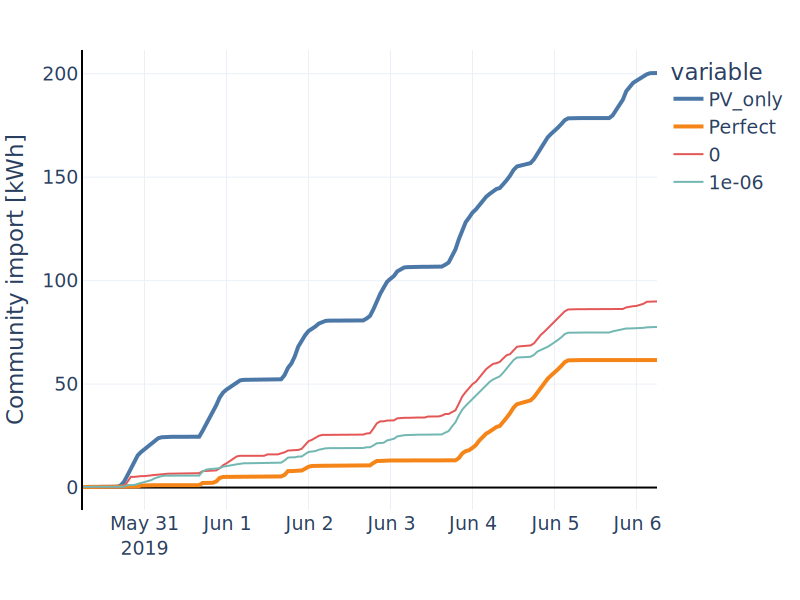

                        PV_only    Perfect          0     1e-06
Index                                                          
2019-06-06 06:00:00  200.357695  61.605633  89.960656  77.60817


In [18]:
graph = community_import_graph()
graph = graph.cumsum(axis=0) / 4
graph = graph.resample("60T").last()

fig = px.line(graph.loc[:end_complete_pred, ["PV_only", "Perfect"] + aging_costs])

fig.data[0].update(line_width=4)
fig.data[1].update(line_width=4)
fig.update_layout(
    layout,
    height=600,
    width=800,
    showlegend=True,
    xaxis_title="",
    yaxis_title="Community import [kWh]",
    yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
    xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
    xaxis_tickangle=0)
fig.show()
#fig.write_image(f"results/cumsum_new_objective_func.svg")
print(graph.tail(1))

In [19]:
(graph.iloc[-1]["PV_only"] - graph.iloc[-1][aging_costs[-1]]) * 100 / (graph.iloc[-1]["PV_only"] - graph.iloc[-1]["Perfect"])

88.46681146664196

In [20]:
(graph.iloc[-1]["PV_only"] - graph.iloc[-1][aging_costs[0]]) * 100 / (graph.iloc[-1]["PV_only"] - graph.iloc[-1]["Perfect"])

79.5642511355404

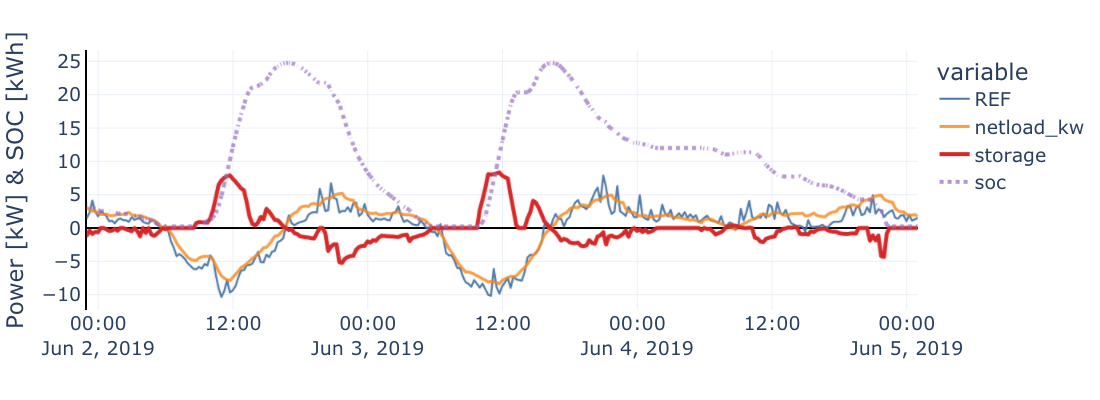

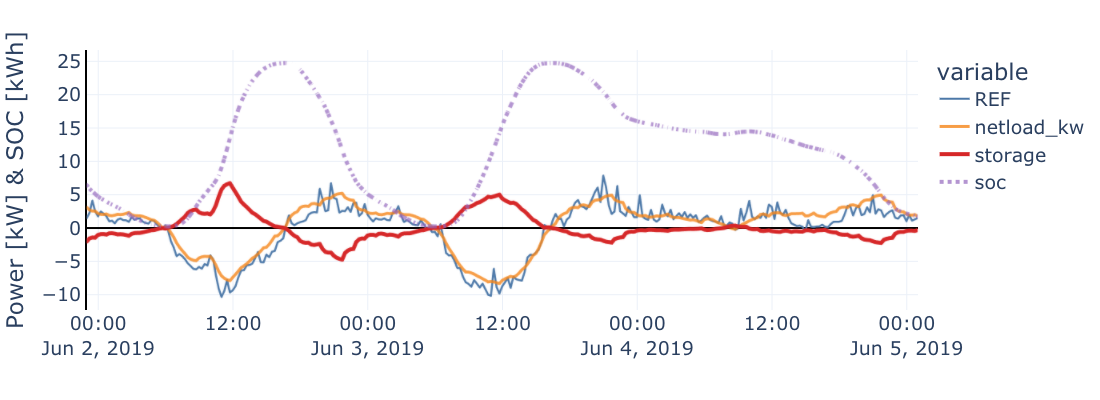

In [22]:
freq = freqs[0]
freq_delta = freq_deltas[0]

for aging_cost in aging_costs:
    # Concat forecasts
    size = len(house_forecast_list[freq])
    tmp = []
    for i in range(0, size):
        tmp_start = house_forecast_list[freq][i].index[0]
        tmp.append(house_forecast_list[freq][i].loc[tmp_start:tmp_start + freq_delta, :].copy())
    graph = pd.concat(tmp, axis=0)
    graph = graph.loc[:end_complete_pred, :]
    graph = graph.loc[datetime(2019, 6, 1, 23, 0, 0):datetime(2019, 6, 5, 1, 0, 0), :]

    graph["netload_kw"] = graph.loc[:end_complete_pred, sub_house_ids].sum(axis=1)
    graph.drop(sub_house_ids, axis=1, inplace=True)

    graph["REF"] = individuals.loc[graph.index[0]:graph.index[-1], sub_house_ids].sum(axis=1)

    graph["storage"] = schedules_concat[aging_cost].sum(axis=1)
    graph["soc"] = energy_concat[aging_cost].sum(axis=1)

    fig = px.line(graph, y=["REF", "netload_kw", "storage", "soc"])
    fig.data[1].update(line_width=3, opacity=0.8)
    fig.data[2].update(line_width=4, 
                       line_color="rgba(214, 39, 40, 1.0)")
    fig.data[3].update(line_width=4, 
                       line_dash="dot", line_color="rgba(148, 103, 189, 0.7)")
    fig.update_layout(
        layout,
        height=400,
        width=1100,
        showlegend=True,
        xaxis_title="",
        yaxis_title="Power [kW] & SOC [kWh]",
        yaxis_dtick=5,
        yaxis_showline=True, yaxis_linewidth=2, yaxis_linecolor='black',
        xaxis_showline=False, xaxis_linewidth=2, xaxis_linecolor='black',
        xaxis_tickangle=0)
    fig.show(renderer="png")
    #fig.write_image(f"results/new_objective_function.svg")

## Compare in €

In [23]:
def community_bill(df, member_ids, timing, deltat=15, buy_price=0.1740, exchange_price=0.0371):
    """Return cost for the community
    cost = buy [€/kWh] imports + pay fees on exchanges [€]
    """
    # Community import (sum then max)
    pos_netload = (
        (
            df[[a for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
            #- df[[prod_col for a in member_ids]].groupby(pd.Grouper(freq=timing)).sum().sum(axis=1)
        )
        .clip(lower=0)
        .sum()
        * deltat
        / 60
    )

    # Sum of ind import (max then sum)
    pos_n_netload = (
        sum(
            (df[a]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            #(df[a] - df[prod_col]).groupby(pd.Grouper(freq=timing)).sum().clip(lower=0).sum()
            for a in member_ids
        )
        * deltat
        / 60
    )

    return np.round(
        buy_price * pos_netload + exchange_price * (pos_n_netload - pos_netload), 3
    )

In [24]:
_start = end_training + deltat
_end = end_complete_pred

In [25]:
for aging_cost in aging_costs:
    graph = schedules_concat[aging_cost].copy()
    graph.columns = sub_house_ids
    for col in graph.columns:
        graph[col] += individuals.loc[_start:_end, col]

    forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
    print(f"Forecast at {aging_cost} cost = {np.round(forecast_cost, 2)} €")

Forecast at 0 cost = 17.43 €
Forecast at 1e-06 cost = 14.94 €


Note 17.43€ is more than 16.8€ from MPC1, different schedule between GLPK and Gurobi.

In [26]:
graph = perfect_schedules_concat.copy()
graph.columns = sub_house_ids
for col in graph.columns:
    graph[col] += individuals.loc[_start:_end, col]

forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Optimization cost = {np.round(forecast_cost, 2)} €")

Optimization cost = 11.61 €


In [27]:
graph = individuals.loc[_start:_end, sub_house_ids].copy()

forecast_cost = community_bill(graph, sub_house_ids, timing="15T", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"PV only cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="1D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical 1d cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="2D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical 2d cost = {np.round(forecast_cost, 2)} €")

forecast_cost = community_bill(graph, sub_house_ids, timing="365D", deltat=15, buy_price=0.1740, exchange_price=0.0371)
print(f"Theoretical cost = {np.round(forecast_cost, 2)} €")

PV only cost = 35.33 €
Theoretical 1d cost = 7.89 €
Theoretical 2d cost = 2.33 €
Theoretical cost = 0.0 €
